In [1]:
!pip install textblob


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import re, string, unicodedata
from string import punctuation
from termcolor import colored
from collections import Counter

from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split

# ✅ Dùng tensorflow.keras thay cho keras standalone
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau

import nltk
from nltk.corpus import stopwords
from textblob import Word
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud, STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk import pos_tag
from nltk.corpus import wordnet

from warnings import filterwarnings
filterwarnings('ignore')

from sklearn import set_config
set_config(print_changed_only=False)

# ✅ Cập nhật cho phiên bản pandas mới (tránh lỗi -1 bị deprecated)
pd.set_option("display.max_colwidth", None)

print(colored("\nNECESSARY LIBRARIES WERE SUCCESSFULLY IMPORTED...", color="green", attrs=["bold", "dark"]))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...



NECESSARY LIBRARIES WERE SUCCESSFULLY IMPORTED...


In [4]:
from google.colab import files
uploaded = files.upload()


Saving spam (1).csv to spam (1).csv


In [5]:
data = pd.read_csv("spam (1).csv", encoding="ISO-8859-1", engine="python")


print(colored("\nDATASETS WERE SUCCESFULLY LOADED...",  color = "green", attrs = ["bold", "dark"]))


DATASETS WERE SUCCESFULLY LOADED...


In [ ]:
data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives around here though",NaN,NaN,NaN


In [6]:
#rename dataset columns
data.rename(columns = {"v1": "target", "v2": "text"}, inplace = True)

#drop unnecessary columns
data.drop(["Unnamed: 2","Unnamed: 3", "Unnamed: 4"], axis = 1, inplace = True)

print(colored("\nOPERATIONS ON DATASETS WERE SUCCESFULLY COMPLETED...",  color = "green", attrs = ["bold", "dark"]))



OPERATIONS ON DATASETS WERE SUCCESFULLY COMPLETED...


In [7]:
data.head()

,target,text
0,ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives around here though"


In [8]:
data.info(memory_usage = True, verbose = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   target  5572 non-null   object
 1   text    5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [ ]:
print(colored("There are {} duplicated values in the dataset".format(data.duplicated().sum()), color = "green", attrs = ["bold", "dark"]))

There are 403 duplicated values in the dataset


In [9]:
data.drop_duplicates(inplace = True)

print(colored("\nDUPLICATED VALUES WERE SUCCESFULLY DROPPED...", color = "green", attrs = ["bold", "dark"]))


DUPLICATED VALUES WERE SUCCESFULLY DROPPED...


In [10]:
grouped_target = data.groupby("target").count()
grouped_target["text"]

,text
target,
ham,4516
spam,653


In [11]:
data.isnull().sum()

,0
target,0
text,0


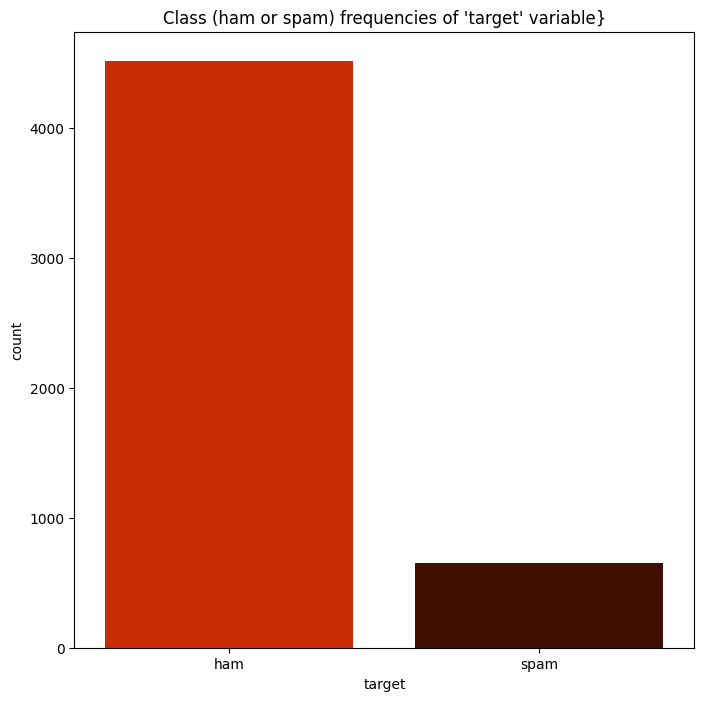

In [12]:
plt.figure(figsize = [8, 8], clear = True, facecolor = "white")

sns.barplot(x = data["target"].value_counts().index,
            y = data["target"].value_counts(), palette = ["#C82C02", "#410F01"],
            saturation = 1).set(title = "Class (ham or spam) frequencies of 'target' variable}");

In [18]:
fig = px.pie(data_frame = data, names = "target", hole = 0.4, title = "counts in 'target' variable",
             width = 1000, height = 500, color_discrete_sequence = px.colors.sequential.Sunset_r)

fig.update_traces(textposition = "inside", textinfo = "percent+label",
                  marker = dict(line = dict(width = 1.5, color = "#410F01")))

fig.update_layout(title_x = 0.5, title_font = dict(size = 30), uniformtext_minsize = 25)

fig.show()


In [13]:
data["text"] = data["text"].apply(lambda x: " ".join(x.lower() for x in x.split()))

print(colored("\nUPPERCASE LETTERS WERE SUCCESFULLY CONVERTED INTO LOWERCASE LETTERS...", color = "green", attrs = ["bold", "dark"]))


UPPERCASE LETTERS WERE SUCCESFULLY CONVERTED INTO LOWERCASE LETTERS...


In [14]:
data["text"] = data["text"].str.replace('[^\w\s]','')

print(colored("\nPUNCTUATION MARKS WERE SUCCESFULLY DELETED...", color = "green", attrs = ["bold", "dark"]))


PUNCTUATION MARKS WERE SUCCESFULLY DELETED...


In [15]:
data["text"] = data["text"].str.replace('\d','')

print(colored("\nNUMBERS WERE SUCCESFULLY DELETED...", color = "green", attrs = ["bold", "dark"]))



NUMBERS WERE SUCCESFULLY DELETED...


In [16]:
stop_words = set(stopwords.words("english"))
punctuation = list(string.punctuation)
stop_words.update(punctuation)

data["text"] = data["text"].apply(lambda x: " ".join(x for x in x.split() if x not in stop_words))

print(colored("\nSTOPWORDS AND PUNCTUATION WERE SUCCESFULLY DELETED ...", color = "green", attrs = ["bold", "dark"]))


STOPWORDS AND PUNCTUATION WERE SUCCESFULLY DELETED ...


In [17]:
data["text"] = data["text"].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

print(colored("\nTEXTS WERE SUCCESFULLY LEMMATIZED...", color = "green", attrs = ["bold", "dark"]))


TEXTS WERE SUCCESFULLY LEMMATIZED...


In [19]:
data["text"] = data["text"].apply(lambda x: " ".join(re.sub(r'http\S+', '', x) for x in x.split()))

print(colored("\nURLs WERE SUCCESFULLY REMOVED...", color = "green", attrs = ["bold", "dark"]))


URLs WERE SUCCESFULLY REMOVED...


In [20]:
data["text"] = data["text"].apply(lambda x: ' '.join([x for x in x.split() if len(x) > 3]))

print(colored("\nWORDS LESS THAN 3 LETTERS LONG WERE SUCCESFULLY REMOVED...", color = "green", attrs = ["bold", "dark"]))



WORDS LESS THAN 3 LETTERS LONG WERE SUCCESFULLY REMOVED...


In [21]:
data.head(n = 10)

,target,text
0,ham,"jurong point, crazy.. available bugis great world buffet... cine amore wat..."
1,ham,lar... joking oni...
2,spam,free entry wkly comp final tkts 21st 2005. text 87121 receive entry question(std rate)t&c's apply 08452810075over18's
3,ham,early hor... already say...
4,ham,"think usf, life around though"
5,spam,"freemsg darling week's word back! like still? chgs send, å£1.50"
6,ham,even brother like speak treat like patent.
7,ham,request 'melle melle (oru minnaminunginte nurungu vettam)' callertune callers. press copy friend callertune
8,spam,winner!! valued network customer selected receivea å£900 prize reward! claim call 09061701461. claim code kl341. valid hour only.
9,spam,mobile month more? entitled update latest colour mobile camera free! call mobile update free 08002986030


In [22]:
corpus = []
for i in data.text:
    for j in i.split():
        corpus.append(j.strip())

In [23]:
counter = Counter(corpus)
common_words = counter.most_common(15)
dict(common_words)

{'call': 483,
 '&lt;#&gt;': 254,
 'like': 227,
 'know': 221,
 'come': 214,
 'free': 201,
 'want': 198,
 'good': 183,
 'text': 179,
 'time': 179,
 'need': 168,
 'send': 161,
 'going': 155,
 'love': 155,
 'still': 143}

<function matplotlib.pyplot.show(close=None, block=None)>

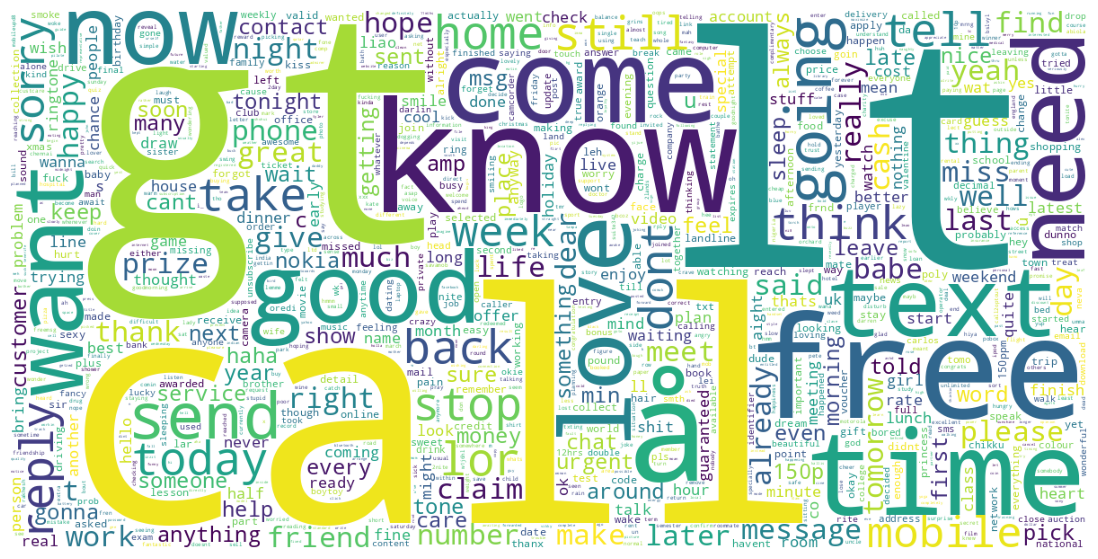

In [24]:
text = " ".join(i for i in data.text)

wc = WordCloud(background_color = "white", width = 1200, height = 600,
               contour_width = 0, contour_color = "#410F01", max_words = 1000,
               scale = 1, collocations = False, repeat = True, min_font_size = 1)

wc.generate(text)

plt.figure(figsize = [15, 7])
plt.imshow(wc)
plt.axis("off")
plt.show

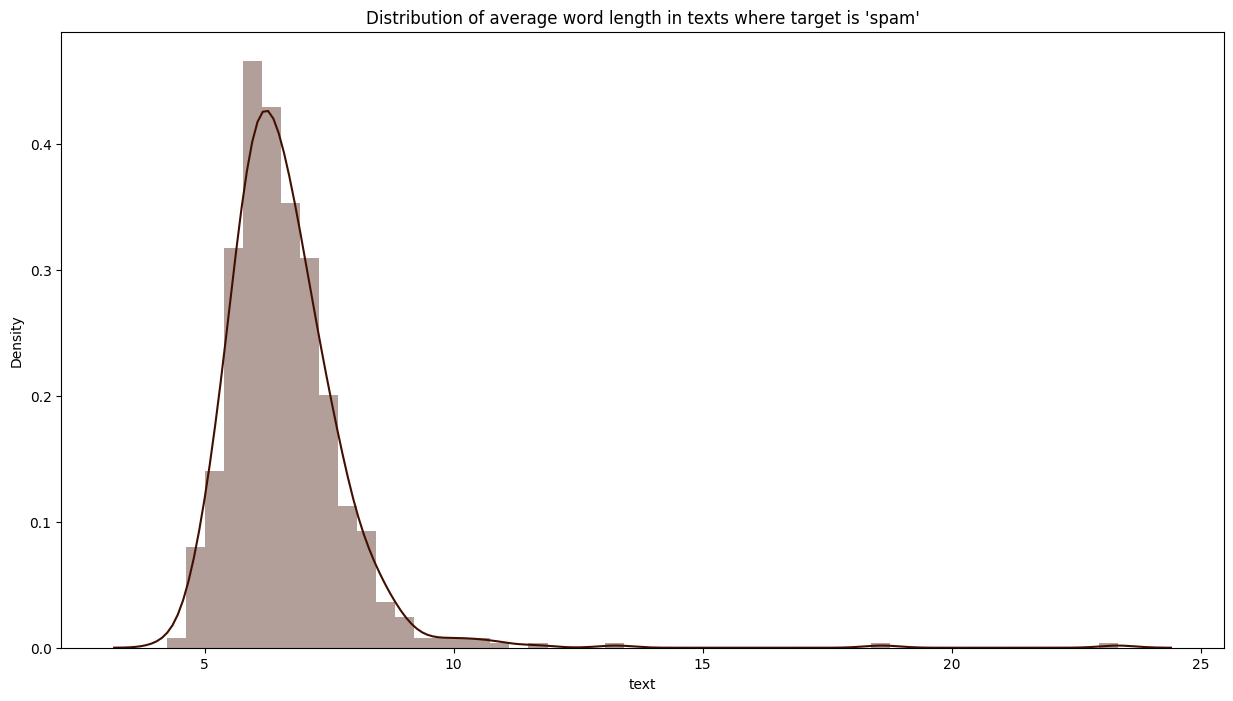

In [25]:
fig,ax = plt.subplots(figsize = (15, 8))
text_words = data[data["target"] == "spam"]["text"].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(text_words.map(lambda x: np.mean(x)), color = "#410F01", ax = ax).set_title("Distribution of average word length in texts where target is 'spam'");

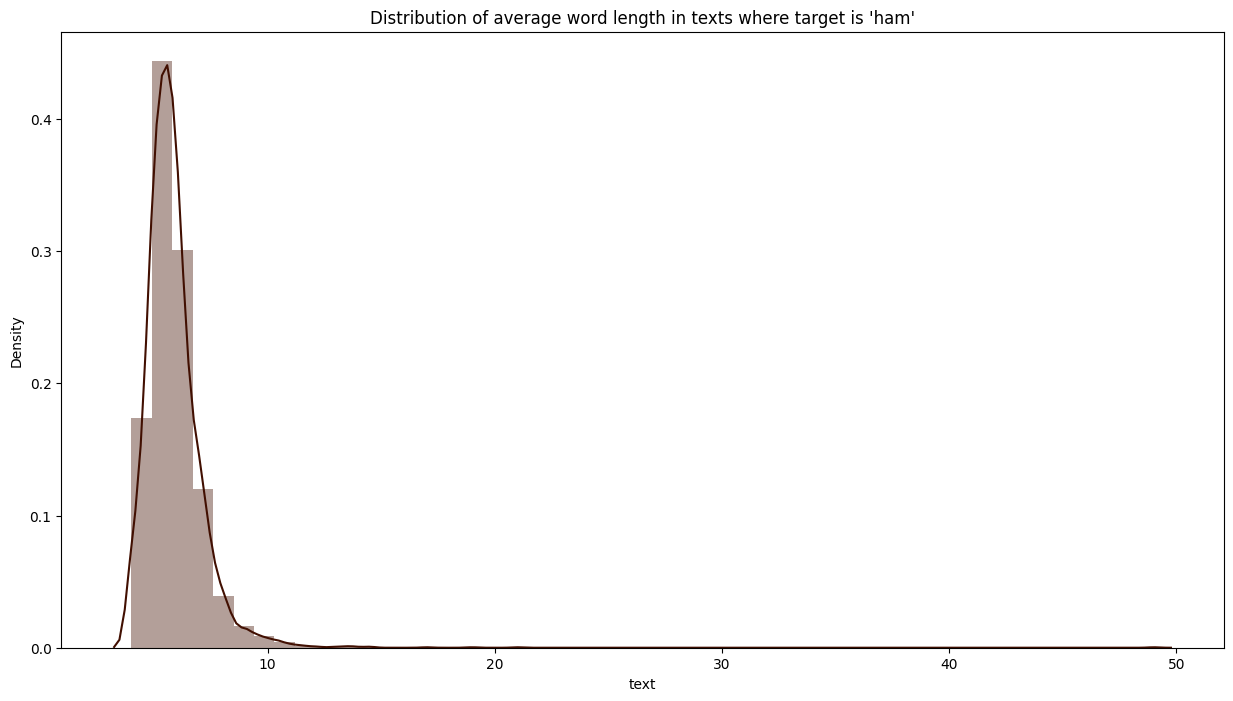

In [26]:
fig,ax = plt.subplots(figsize = (15, 8))
text_words = data[data["target"] == "ham"]["text"].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(text_words.map(lambda x: np.mean(x)), color = "#410F01", ax = ax).set_title("Distribution of average word length in texts where target is 'ham'");

In [27]:
lb = LabelEncoder()
data["target"] = lb.fit_transform(data["target"])

In [28]:
x = data["text"]
y = data["target"]

train_x, test_x, train_y, test_y = train_test_split(x, y, test_size = 0.20, shuffle = True, random_state = 11)

print(colored("\nDATASET WAS SUCCESFULLY DIVIDED ...", color = "green", attrs = ["bold", "dark"]))


DATASET WAS SUCCESFULLY DIVIDED ...


In [29]:
print("The shape of 'train_x' is {} and the shape of 'test_x' is {}".format(train_x.shape[0], test_x.shape[0]))

The shape of 'train_x' is 4135 and the shape of 'test_x' is 1034


In [30]:
tokenizer = Tokenizer(num_words = None)
tokenizer.fit_on_texts(train_x)

tokenized_train = tokenizer.texts_to_sequences(train_x)
tokenized_test = tokenizer.texts_to_sequences(test_x)

train_x = pad_sequences(tokenized_train, maxlen=None)
test_x = pad_sequences(tokenized_test, maxlen=None)

In [31]:
from google.colab import files
uploaded = files.upload()


Saving glove.twitter.27B.50d.txt to glove.twitter.27B.50d.txt


In [34]:
GLOVE_EMBEDDING = "glove.twitter.27B.50d.txt"

In [36]:
import numpy as np

# ====== 1. Cấu hình ======
MAX_NUM_WORDS = 10000  # Số từ giữ lại trong tokenizer
EMBEDDING_DIM = 50    # Kích thước vector GloVe

# ====== 2. Hàm tách từ và vector ======
def get_coefs(word, *arr):
    return word, np.asarray(arr, dtype="float32")

# ====== 3. Nạp file GloVe ======
embeddings_index = {}
with open(GLOVE_EMBEDDING, encoding='utf-8') as f:
    for line in f:
        values = line.rstrip().rsplit(" ")
        word, vector = get_coefs(*values)
        embeddings_index[word] = vector

# ====== 4. Thống kê trung bình & độ lệch chuẩn của toàn bộ embedding ======
embeddings = np.stack(list(embeddings_index.values()))
embedding_mean, embedding_std = embeddings.mean(), embeddings.std()

# ====== 5. Lấy word_index và giới hạn số từ ======
word_index = tokenizer.word_index
nb_words = min(MAX_NUM_WORDS, len(word_index)) + 1  # +1 để chứa padding (0)

# ====== 6. Tạo ma trận embedding (ngẫu nhiên ban đầu) ======
embedding_matrix = np.random.normal(embedding_mean, embedding_std, (nb_words, EMBEDDING_DIM))

# ====== 7. Gán vector từ GloVe nếu tồn tại ======
for word, i in word_index.items():
    if i >= nb_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

lr_reduce = ReduceLROnPlateau(monitor = "val_accuracy", patience = 2, factor = 0.5, min_lr = 0.00001)

In [38]:
model = Sequential()

model.add(Embedding(
    input_dim=nb_words,
    output_dim=50,
    weights=[embedding_matrix],
    trainable=False
))

# Các lớp tiếp theo giữ nguyên
model.add(LSTM(units=128, return_sequences=True, recurrent_dropout=0.3, dropout=0.5))
model.add(LSTM(units=64, recurrent_dropout=0.3, dropout=0.5))
model.add(Dense(units=32, activation="relu"))
model.add(Dense(1, activation="sigmoid"))

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              loss="binary_crossentropy",
              metrics=["accuracy"])


In [39]:
history = model.fit(
    train_x,
    train_y,
    batch_size=64,
    validation_data=(test_x, test_y),
    epochs=2,
    callbacks=[lr_reduce]
)

Epoch 1/2
65/65 ━━━━━━━━━━━━━━━━━━━━ 49s 570ms/step - accuracy: 0.8902 - loss: 0.2506 - val_accuracy: 0.9507 - val_loss: 0.1340 - learning_rate: 0.0100
Epoch 2/2
65/65 ━━━━━━━━━━━━━━━━━━━━ 77s 564ms/step - accuracy: 0.9588 - loss: 0.1132 - val_accuracy: 0.9497 - val_loss: 0.1232 - learning_rate: 0.0100


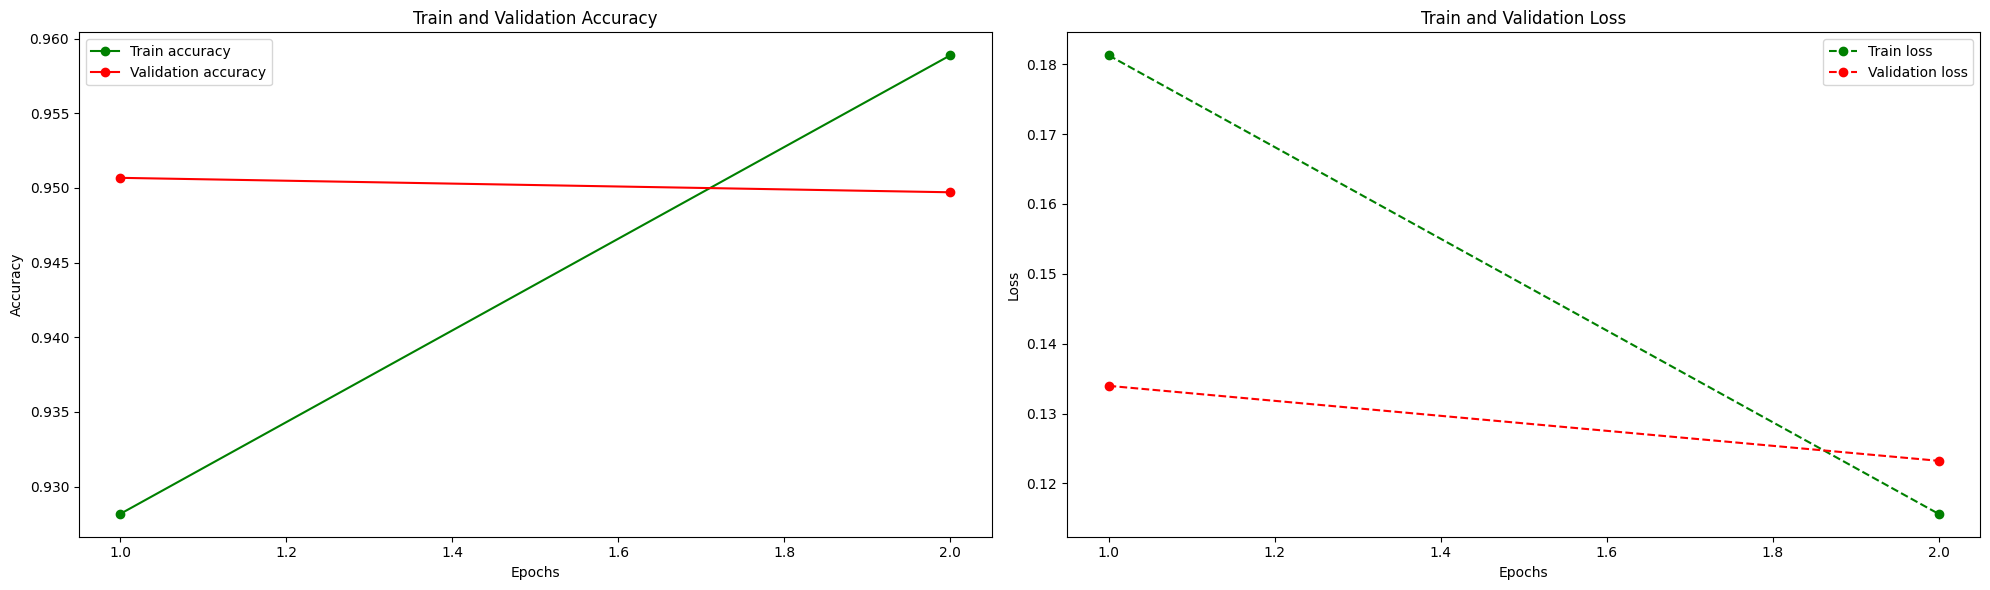

In [40]:
train_acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
train_loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1, len(train_acc) + 1)

fig, ax = plt.subplots(1, 2, figsize=(20, 6))

# Accuracy
ax[0].plot(epochs, train_acc, "go-", label="Train accuracy")
ax[0].plot(epochs, val_acc, "ro-", label="Validation accuracy")
ax[0].set_title("Train and Validation Accuracy")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")
ax[0].legend()

# Loss
ax[1].plot(epochs, train_loss, "go--", label="Train loss")
ax[1].plot(epochs, val_loss, "ro--", label="Validation loss")
ax[1].set_title("Train and Validation Loss")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
ax[1].legend()

plt.tight_layout()
plt.show()

In [41]:
prediction = model.predict(test_x)
classes_pred = (model.predict(test_x) > 0.5).astype("int32")

print(classification_report(test_y, classes_pred))

33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 94ms/step
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       896
           1       0.95      0.66      0.78       138

    accuracy                           0.95      1034
   macro avg       0.95      0.83      0.87      1034
weighted avg       0.95      0.95      0.95      1034



[[891   5]
 [ 47  91]]


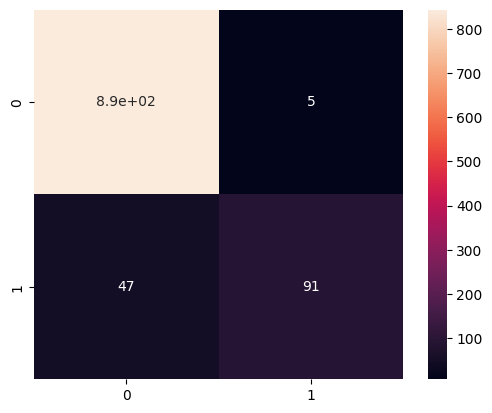

In [42]:
conf_mat = confusion_matrix(test_y, classes_pred)
print(conf_mat)

sns.heatmap(conf_mat, square = True, annot = True, robust = True)
plt.show()

In [44]:
import re
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Hàm tiền xử lý văn bản giống như khi huấn luyện
def preprocess_text(text):
    text = text.lower()  # chuyển về chữ thường
    text = re.sub(r'\d+', '', text)  # xóa số
    text = re.sub(r'[^\w\s]', '', text)  # xóa dấu câu
    text = re.sub(r'\s+', ' ', text).strip()  # xóa khoảng trắng thừa
    return text

# 👤 Nhập tin nhắn cần kiểm tra
user_input = input("Nhập tin nhắn cần kiểm tra: ")

# Tiền xử lý
cleaned_input = preprocess_text(user_input)

# 🧠 Tokenize + Padding (phải dùng đúng tokenizer và maxlen như lúc huấn luyện)
seq = tokenizer.texts_to_sequences([cleaned_input])
padded = pad_sequences(seq, maxlen=100)  # Thay 100 bằng maxlen bạn đã dùng khi huấn luyện

# 🔮 Dự đoán
prediction = model.predict(padded)

# 🎯 Hiển thị kết quả
confidence = prediction[0][0]
label = 'SPAM' if confidence > 0.5 else 'NOT SPAM'
print(f"\n👉 Tin nhắn được dự đoán là: {label} (Xác suất: {confidence:.2%})")


Nhập tin nhắn cần kiểm tra: dmm
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step

👉 Tin nhắn được dự đoán là: NOT SPAM (Xác suất: 0.42%)
